In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
class European_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, sample_size = 10000, confidence_level = 0.95):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.sample_size = sample_size
        self.confidence_level = confidence_level

    def d1(self):
        return (np.log(self.S0 / self.K) + (self.r + 0.5 * self.sigma ** 2)) * self.T / (self.sigma * np.sqrt(self.T))

    def d2(self):
        return (np.log(self.S0 / self.K) + (self.r - 0.5 * self.sigma ** 2)) * self.T / (self.sigma * np.sqrt(self.T))

    def Black_Sholes_Price(self):
        
        if self.option_type == "call":
            price = self.S0 * norm.cdf(self.d1()) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2())

        elif self.option_type == "put":
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2()) - self.S0 * norm.cdf(-self.d1())

        else:
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")
        
        return price

    def Monte_Carlo_Price(self):
        G = npr.normal(0, 1, size = (self.sample_size, 1))
        ST = self.S0 * np.exp((self.r - 0.5 * self.sigma ** 2) * self.T + self.sigma * np.sqrt(self.T) * G)

        if self.option_type == "call":
            payoff = np.exp(-self.r * self.T) * np.maximum(ST - self.K, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf(self.confidence_level)
            confidence_interval = [price - error, price + error]
            
        elif self.option_type == "put":
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - ST, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf(self.confidence_level)
            confidence_interval = [price - error, price + error]

        else: 
            raise ValueError("Invalid Option Type: it must be 'call' or 'put'")

        return price, confidence_interval

In [3]:
option = European_Option(
    S0 = 100,               # Spot price of 100
    K = 90,                 # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

print(f"Black-Sholes Option price: {option.Black_Sholes_Price():.2f}")
mc_price, mc_confidence_interval = option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.2f}")
print(f"95% Confidence Interval: [{mc_confidence_interval[0]:.2f}, {mc_confidence_interval[1]:.2f}]")

Black-Sholes Option price: 16.70
Monte Carlo Option Price: 16.54
95% Confidence Interval: [14.90, 18.18]


In [91]:
class Brownian_Motion:
    def __init__(self, T, time_grid = 1000, sample_size = 5):
        self.T = T
        self.time_grid = time_grid
        self.sample_size = sample_size

    def Brownian_Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        increments = np.sqrt(self.T / self.time_grid) * G
        path = np.cumsum(increments, axis = 1)
        path = np.concatenate((np.zeros((self.sample_size, 1)), path), axis = 1)

        return path

    def Plot_Path(self):
        path = self.Brownian_Path()
        time_points = np.linspace(0, self.T, self.time_grid + 1)
        for i in range(self.sample_size):
            plt.plot(time_points, path[i], label = f'Path {i + 1}' if self.sample_size <= 5 else None)
        plt.title(f'Simulated Brownian Paths ({self.sample_size} paths)')
        plt.xlabel('Time')
        plt.ylabel('Position')
        plt.grid(True)
        if self.sample_size <= 5:
            plt.legend()
        plt.show()

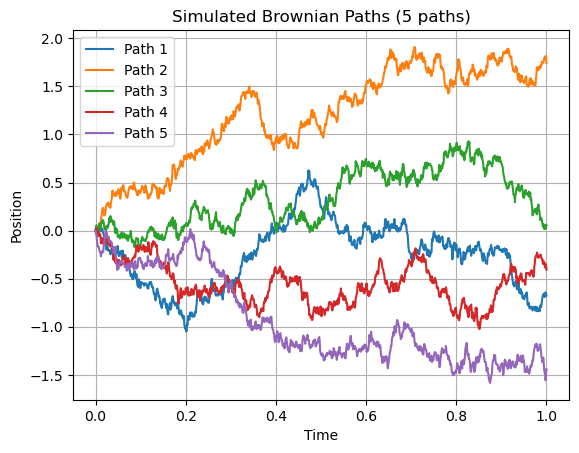

In [93]:
brownian_motion = Brownian_Motion(
    T = 1
)

brownian_motion.Plot_Path()

In [167]:
class Asian_Option:
    def __init__(self, S0, K, T, sigma, r, option_type, sample_size = 10000, confidence_level = 0.95, time_grid = 1000):
        self.S0 = S0
        self.K = K
        self.T = T
        self.sigma = sigma
        self.r = r
        self.option_type = option_type
        self.sample_size = sample_size
        self.confidence_level = confidence_level
        self.time_grid = time_grid

    def Path(self):
        G = npr.normal(0, 1, size = (self.sample_size, self.time_grid))
        log_increments = (self.r - 0.5 * self.sigma ** 2) * np.sqrt(self.T / self.time_grid) + self.sigma * np.sqrt(self.T / self.time_grid) * G
        log_path = np.concatenate((np.log(self.S0) * np.ones((self.sample_size, 1)), log_increments), axis = 1)
        log_path = np.cumsum(log_path, axis = 1)
        path = np.exp(log_path)

        return path

    def Riemann_Integral(self):
        path = self.Path()
        integral = np.mean(path, axis = 1) 

        return integral

    def Trapezoidal_Integral(self):
        path = self.Path()
        integral = (self.T / self.time_grid) * ((path[:, 0] + path[:, -1]) / 2 + np.sum(path[:, 1:-1], axis = 1))

        return integral

    def Simpson_Integral(self):
        path = self.Path()
        integral = (self.T / self.time_grid) / 3 * (path[:, 0] + 4 * np.sum(path[:, 1:-1:2]) + 2 * np.sum(path[:, 2:-1:2]) + path[:, -1])

        return integral

    def Monte_Carlo_Price(self):

        if self.option_type == "call":
            integral = self.Simpson_Integral()
            payoff = np.exp(-self.r * self.T) * np.maximum(integral - self.K, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf(self.confidence_level)
            confidence_interval = [price - error, price + error]

        if self.option_type == "put":
            integral = self.Riemann_Integral()
            payoff = np.exp(-self.r * self.T) * np.maximum(self.K - integral, 0)
            price = np.mean(payoff)
            standard_deviation = np.std(payoff)
            error = norm.ppf(self.confidence_level)
            confidence_interval = [price - error, price + error]

        return price, confidence_interval

In [169]:
option = Asian_Option(
    S0 = 100,               # Spot price of 100
    K = 90,                 # Strike price of 90
    T = 1,                  # Maturity of 1 year
    sigma = 0.2,            # 20% volatility
    r = 0.05,               # 5% risk-free rate
    option_type = "call"    # Option Type
)

mc_price, mc_confidence_interval = option.Monte_Carlo_Price()
print(f"Monte Carlo Option Price: {mc_price:.2f}")
print(f"95% Confidence Interval: [{mc_confidence_interval[0]:.2f}, {mc_confidence_interval[1]:.2f}]")

Monte Carlo Option Price: 1602041.45
95% Confidence Interval: [1602039.80, 1602043.09]
